## 텐초 파이토치 딥러닝 특강
***
### Day 02
### < 사진 분류하기 >

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [3]:
train = CIFAR10(root = "./", train = True, download = True, transform = ToTensor())
test = CIFAR10(root = "./", train = False, download = True, transform = ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


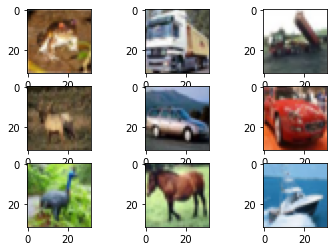

In [4]:
for i in range(9) :
  plt.subplot(3, 3, i + 1)
  plt.imshow(train.data[i])

plt.show()

In [5]:
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomCrop, ToPILImage

In [12]:
transforms = Compose([ToPILImage(),
                      RandomCrop((32, 32), padding = 4),
                      RandomHorizontalFlip(p = .5)
                      ])

이미지 데이터 전처리시 Compose 안에 전처리 방식 입력하면 됨
- RandomCrop -> 이미지를 임의의 사이즈로 잘라낸다.
- RandomHorizontalFlip -> 이미지를 y축으로 확률만큼 대칭

In [13]:
train = CIFAR10(root = "./", train = True, download = True, transform = transforms)
test = CIFAR10(root = "./", train = False, download = True, transform = transforms)

Files already downloaded and verified
Files already downloaded and verified


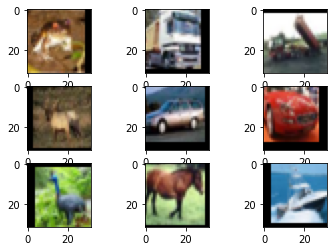

In [14]:
for i in range(9) :
  plt.subplot(3, 3, i + 1)
  plt.imshow(transforms(train.data[i]))

plt.show()

In [6]:
import torchvision.transforms as T
from torchvision.transforms import Normalize

In [20]:
normalize_transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding = 4),
    RandomHorizontalFlip(p = 0.5),
    T.ToTensor(),
    Normalize(mean = (0.4914, 0.4822, 0.4465), std = (0.247, 0.243, 0.261)),
    T.ToPILImage()
])

In [21]:
normalized_train = CIFAR10(root = "./", train = True, download = False, transform = normalize_transforms)
normalized_test = CIFAR10(root = "./", train = False, download = False, transform = normalize_transforms)

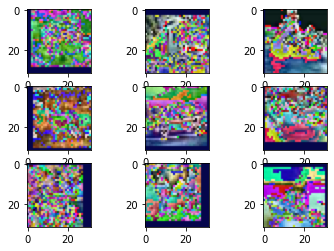

In [11]:
for i in range(9) :
  plt.subplot(3, 3, i + 1)
  plt.imshow(normalize_transforms(normalized_train.data[i]))

plt.show()

### nn.Module을 활용하여 커스텀 계층 구성

In [15]:
import torch.nn as nn

In [38]:
class BasicBlock(nn.Module) :

  def __init__(self, in_channels, out_channels, hidden_dims) :

    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, hidden_dims, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(hidden_dims, out_channels, kernel_size = 3, padding = 1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x) :

    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    return x

모듈의 __init__() 함수는 모듈의 초기화를 담당한다. super()는 상속 받은 부모 클래스의 요소를 사용하는 함수

In [39]:
class CNN(nn.Module) :

  def __init__(self, num_classes) :

    super(CNN, self).__init__()

    self.block1 = BasicBlock(in_channels = 3, out_channels = 32, hidden_dims = 16)
    self.block2 = BasicBlock(in_channels = 32, out_channels = 128, hidden_dims = 64)
    self.block3 = BasicBlock(in_channels = 128, out_channels = 256, hidden_dims = 128)

    self.fc1 = nn.Linear(in_features = 4096, out_features = 2048)
    self.fc2 = nn.Linear(in_features = 2048, out_features = 256)
    self.fc3 = nn.Linear(in_features = 256, out_features = num_classes)

    self.relu = nn.ReLU()

  def forward(self, x) :

    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim = 1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)

    return x

In [43]:
from torch.utils.data.dataloader import DataLoader
import torch
from torch.optim import Adam

In [51]:
transforms = Compose([
    RandomCrop((32, 32), padding = 4),
    RandomHorizontalFlip(p = 0.5),
    T.ToTensor(),
    Normalize(mean = (0.4914, 0.4822, 0.4465), std = (0.247, 0.243, 0.261))
])

In [52]:
train = CIFAR10(root = "./", train = True, download = False, transform = transforms)
test = CIFAR10(root = "./", train = False, download = False, transform = transforms)

In [55]:
tr_loader = DataLoader(train, batch_size = 128, shuffle = True)
te_loader = DataLoader(test, batch_size = 128, shuffle = False)

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [60]:
model = CNN(num_classes = 10)

In [61]:
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

#### 모델 학습

In [62]:
lr = 0.001

In [63]:
optim = Adam(model.parameters(), lr = lr)

In [64]:
for epoch in range(100) :

  for data, label in tr_loader :

    optim.zero_grad()

    pred = model(data.to(device))

    loss = nn.CrossEntropyLoss()(pred, label.to(device))
    loss.backward()
    optim.step()

  if epoch == 0 or epoch % 10 == 9 :
    print(f"Epoch {epoch + 1} Loss : {loss.item()}")

torch.save(model.state_dict(), 'CIFAR.pth')

Epoch 1 Loss : 1.263254165649414
Epoch 10 Loss : 0.6027519106864929
Epoch 20 Loss : 0.2610251307487488
Epoch 30 Loss : 0.37280306220054626
Epoch 40 Loss : 0.14141930639743805
Epoch 50 Loss : 0.10494165122509003
Epoch 60 Loss : 0.10165715217590332
Epoch 70 Loss : 0.08982239663600922
Epoch 80 Loss : 0.07507440447807312
Epoch 90 Loss : 0.09899041801691055
Epoch 100 Loss : 0.04724747687578201


#### 모델 성능 평가

In [65]:
model.load_state_dict(torch.load('CIFAR.pth', map_location = device))

<All keys matched successfully>

In [66]:
acc = 0

In [67]:
with torch.no_grad() :

  for data, label in te_loader :

    output = model(data.to(device))
    pred = output.data.max(1)[1]
    correct = pred.eq(label.to(device).data).sum().item()
    acc += correct

  print(f"Accuracy : {acc / len(test)}")

Accuracy : 0.8415
